<a href="https://colab.research.google.com/github/JCuomo/FakeVoice/blob/main/tacotron2_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Colab notebook for installation / training / synthesis of a Tacotron-2 model.

Welcome to my attempt at a comprehensive notebook for training custom tacotron-2 models for audio deepfakes. This is a work in progress, and will recieve periodic updates. I'm an amateur when it comes to all of this, and will gladly accept advice, clarification, useful edits, and optimizations.

**This particular notebook is set up to train from the NVIDIA's published pretrained tacotron2 and waveglow models. The WAV files in your dataset should be Mono, 22050 hz, with 16-bit Microsoft PCM encoding.Each WAV file should be between 2 and 15 seconds. Between 2 and 10 seconds is ideal.**

If you're new to Colab, below are some notes and a couple of the techniques I use to run things:

You can think of a colab notebook as a virtual machine running on a Google server in some far-off datacenter. As a result, anything that is installed/stored on the VM is deleted whenever the session ends. To get around this limitation, you will mount your google drive to the VM instance, and read/write to that directory.

<!> This is your standard bash/command line execution thing. Pop it before a command to execute via the command line instead of as a script.

<%> This is a magics call. Some commands, like cd, won't execute with !. This lets you do that, and is especially useful when condensing code that would normally span multiple cells into a single cell. You might see me cd into a folder without this in some cells--that's because if a command like cd is in a cell alone, "automagics" inserts the % for you. But this doesn't work if it shares a cell with other operations.

**A last important note: make sure you disconnect the runtime when you're done, so google doesn't clock you as using a GPU when you're actually not. Failure to do so may get you downgraded to a worse GPU temporarily.** Go to the "connect" dropdown in the top right corner, select "manage sessions," and then "terminate" to end the session and disconnect the runtime.

---



---



# Environment Preparation

Make sure you're using a GPU runtime -- go to "runtime" at the top of the page > "change runtime type" > select "GPU" under Hardware Accelerator.


Run this cell to check what kind of GPU you're connected to - Since colab is free, you don't get to choose. Anything not P100 or V100 can cause problems; see the bottom of the notebook for troubleshooting.

In [1]:
!pip install --upgrade pip
!pip install -U --ignore-installed wrapt

     |████████████████████████████████| 1.7 MB 17.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
     |████████████████████████████████| 78 kB 7.2 MB/s             
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astroid 2.8.2 requires wrapt<1.13,>=1.11, but you have wrapt 1.13.3 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.23.4 which is incompatible.
tensorflow-gpu 1.15.5 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.


In [2]:
!pip install matplotlib==2.1.0
!pip install tensorflow==1.15.2
!pip install numpy==1.16.4
!pip install inflect==0.2.5
!pip install librosa==0.6.0
!pip install scipy==1.0.0
!pip install Unidecode==1.0.22
!pip install pillow
!pip install eng_to_ipa==0.0.2
!pip install g2p-en==2.1.0
!pip install epitran

     |████████████████████████████████| 15.0 MB 11.2 MB/s            
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.1
    Uninstalling matplotlib-3.2.1:
      Successfully uninstalled matplotlib-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.11.1 requires matplotlib>=2.2, but you have matplotlib 2.1.0 which is incompatible.
     |████████████████████████████████| 110.5 MB 139.9 MB/s            
     |████████████████████████████████| 17.3 MB 21.8 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
seaborn 0.11.1 requires m

     |████████████████████████████████| 323 kB 92.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for librosa: filename=librosa-0.6.0-py3-none-any.whl size=1553494 sha256=490c5f7744ed43aa65231a366b6a24ee82bc7425b1d4bac12826919bb52b4392
  Stored in directory: /home/ec2-user/.cache/pip/wheels/72/c0/f2/b00db6242414bafcbbca59c495a52a1bfd0574f29a7e498dc9
  Created wheel for audioread: filename=audioread-2.1.9-py3-none-any.whl size=23153 sha256=6556f44c6b95d99f0d0dcc5aa73903e12a4185e7370a990286769ca998d9cbc8
  Stored in directory: /home/ec2-user/.cache/pip/wheels/de/14/0a/863e4ed680b3204444cf486733e609d7ff7abe8fceafab67dc
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320732 sha256=996ca0ea808732bd488754ca44d9c202e9f61d24f7c13771955188f421bde522
  Stored in directory: /home/ec2-user/.cache/pip/wheels/cf/d4/04/49d8824a42bd9f9b11d502727965b9997f0d41d2b22ae4f645
Successfully built librosa audioread resampy
     |████████████████████████████

In [3]:
%tensorflow_version 1.x


UsageError: Line magic function `%tensorflow_version` not found.


In [ ]:
!nvidia-smi -L
#P100 = Good
#V100 = Amazing
#T4 = Crap
#P4 = Crap
#K80 = Slow
#This nugget of info copied from the MLP community's tts project/cookiePPP

Install EPITRAN for IPA text preprocessing. This step is strictly optional, but transliteration from English graphemes to language-agnostic phonemes will almost may improve model generalization and pronunciation. ARPABET will likely be better still, and is enabled by default in hparams.py via `preprocessing = "arpabet"`

In [5]:
# You have to do this in root for some reason. If you install into a directory mounted via drive, you get bad interpreter errors.
!pip install epitran
!git clone https://github.com/festvox/flite.git

fatal: destination path 'flite' already exists and is not an empty directory.


In [ ]:
!pip install epitran


In [ ]:
%cd '/content/flite/'
!./configure && make
!sudo make install
%cd '/content/flite/testsuite/'
!make lex_lookup
!sudo cp lex_lookup /usr/local/bin
%cd '/content/'

Mount your google drive. If you haven't mounted a drive via colab before, it just lets you cd in and out of your storage on google drive, and lets you write and read files from this notebook. The directory you see when you go to the normal google drive interface is typically "/content/drive/My Drive". The below cell will create the directory "ML" in your "My Drive" folder if does not already exist, and then drop you into the folder. After mounting, you can access files from the left sidebar. Double click on a file to edit it in a text editor.

NOTE: It's best not to upload large files via the Google Colab sidebar; it doesn't like uploads of more than 10MB or so. It's typically best to upload 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd '/content/drive/'

# import os
# if not os.path.exists('My Drive/ML/'):
#     os.makedirs('My Drive/ML/')
# else:
#     print("\nDirectory " + '"/My Drive/ML"' + " already exists, skipping creation and navigating to directory.\n")

# %cd '/content/drive/My Drive/ML/'

Clone the Audio DeepFakes TacoTron2 repo. Because we're cloning into a subdirectory of your google drive, you should only have to clone the repo the first time you run the notebook. If you need to update your repo, you can run the "!git fetch --all" cell. Note that this will overwrite any changes you've made in your hparams.py file.

In [6]:
!git clone https://github.com/scripples/tacotron2.git

Cloning into 'tacotron2'...
remote: Enumerating objects: 517, done.
remote: Total 517 (delta 0), reused 0 (delta 0), pack-reused 517
Receiving objects: 100% (517/517), 3.58 MiB | 20.82 MiB/s, done.
Resolving deltas: 100% (278/278), done.


Run the following cell if you need to update to the latest version of the repo.

In [7]:
!git fetch --all
!git reset --hard origin/master

Fetching origin
fatal: ambiguous argument 'origin/master': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'


Install the required modules via requirements.txt. You will need to reinstall requirements.txt every time you restart the notebook.

In [ ]:
!apt-get install sox
!pip install -r requirements.txt

After installing it will ask you to restart the runtime. Do so. If you're unable to reconnect, check the troubleshooting segment at the bottom of this notebook.

After retarting the runtime, cd back into the tacotron2 directory.

In [ ]:
cd "tacotron2"

Install the waveglow submodule. Like cloning the repo, you should only need to do this on the first run.

In [10]:
!git submodule init
!git submodule update

Submodule 'waveglow' (https://github.com/NVIDIA/waveglow) registered for path 'waveglow'
Cloning into '/home/ec2-user/SageMaker/FakeVoice/tacotron2/waveglow'...
Submodule path 'waveglow': checked out '5bc2a53e20b3b533362f974cfa1ea0267ae1c2b1'


The following cell will download the pretrained tacotron2 and waveglow models to their appropriate folders. Ignore the tacotron2 folder inside of the waveglow folder. I don't know why they did that, but that particular folder is unused. Again, you will only need to do this on first run.

In [3]:
!pip install gdown
!gdown --id 1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
%cd "tacotron2/waveglow"
!gdown --id 1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF
%cd "tacotron2"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=bd18cc926fa159ba9abf4126cf25e30f719b64e3eaf0d702c9180759d59e49be
  Stored in directory: /home/ec2-user/.cache/pip/wheels/43/b9/ae/9aaa87ea0b7b7d62d46ed76221fd8a93c2a715468d68d097b7
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
To: /home/ec2-user/SageMaker/FakeVoice/tacotron2_statedict.pt
100%|████████████████████████████████████████| 113M/113M [00:01<00:00, 92.5MB/s]
/home/ec2-user/SageMaker/FakeVoice/tacotron2/waveglow
Downloading...
From: https://drive.google.com/uc?id=1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF
To: /home/ec2-user/SageMaker/FakeVoice/tacotron2/waveglow/waveglow_256channels_universal_v5.pt
100%|█████████████████████████████████████████| 676M/676M [00:05<00:00, 129MB/s]
/home/ec2-user/SageMaker/FakeVo

Congratulations! You've just installed Tacotron-2.

# Upload your dataset via Google Drive.

This is where you upload your dataset and the filelists that train.py needs to run. Upload your directory containing the WAV files to the location of your choice. You will need to preprocess your train.txt and val.txt so that the filename also points to the directory of your uploaded files. Also make sure to upload your files through Google Drive, and not through Colab. Colab doesn't like it when you upload 1000+ wav files through its sidebar.

You need three things: A directory containing the WAV files, and two files which contain wav|transcription indexes. You can find an example in filelists/ljs_audio_text_val_filelist.txt. In this case, the wavs are found in the DUMMY directory, and the wavs and transcripts are separated by the "|" character.

In my case, I have my WAVs in "drive/My Drive/ML/Datasets/saltzvoice/wavs". This means that my train.txt and val.txt will look like this:

../Datasets/saltzvoice/wavs/saltz_0731.wav|After that, however, the bump disappears and the debt remains.
../Datasets/saltzvoice/wavs/saltz_0096.wav|If you’re an aspiring artist, I want you to remember: Nothing happens if you’re not working.

So they're pointed up one directory from where train.py is running, and back down into where I'm keeping my wavs.

Next, you need to upload your train.txt and val.txt. I keep them in "/ML/tacotron2/filelists", or in the same folder as the "wavs" folder.

Finally, you need to update hparams.py, which is in the tacotron2 directory. Under Data parameters, update training_files and validation_files to point to the directory containing your training and validation .txt files. Then, under Optimization_Hyperparameters, lower batch_size to something like 16. If you run into an out of memory error, you'll have to lower it even more. If you're training on files at 44.1khz or 32-bit PCM, you'll have to work with a much lower batch size. Lower batch size means slower convergence, and I've heard reports that extremely low batch sizes may have difficulty converging at all.

I also change the iters_per_checkpoint parameter to something like 500, so I can test the model's output every 500 steps, as opposed to every 2000. 2000 makes sense if you're training a model from scratch, but if you're fine-tuning/transfer learning, it may converge much sooner.

In [4]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

--2021-12-06 13:59:31--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G   143MB/s    in 19s     

2021-12-06 13:59:50 (138 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [ ]:
!tar xvfj 'LJSpeech-1.1.tar.bz2'


In [20]:
!pwd

/home/ec2-user/SageMaker/FakeVoice/tacotron2


In [15]:
!mv test.txt dataset/
!mv train.txt dataset/
!mv val.txt dataset/

mv: cannot stat ‘../test.txt’: No such file or directory
mv: cannot stat ‘../train.txt’: No such file or directory
mv: cannot stat ‘../val.txt’: No such file or directory


# Modificaciones
Descargue metadata.csv, le cambie la extension a txt y en notepad agregue la carpeta:  

```
wave_name|transcript   --->  path/wave_name|transcript
```


Despues lo dividi en test, train, val y los cargue al colab

You can use the following cell to preprocess your WAVs for a marginal improvment in training. Depending on the size of your dataset, this may take a minute. Just make sure you're running it from inside the directory containing your WAVs.

In [ ]:
%cd "dataset/wavs/"

In [ ]:
# More code snarfed/adapted from cookie/synthbot

# Adds a slight fade to both ends to prevent pops / sharp noises at the beginning. Ends are then padded with silence and then stripped back, ensures all files have same silence padding.

%%bash

for file in *.wav; do
    cp "$file" "tmp.wav";
    sox -q "tmp.wav" "$file" pad .2 .2 silence 1 0.1 0.1% reverse silence 1 0.1 0.1% reverse;
done

%rm tmp.wav

In [ ]:
%rm tmp.wav


In [ ]:
%cd ..

In [ ]:
!pip install -r requirements.txt



---



---

#Time to train your model. 



---



This cell will train the model, starting with the pretrained weights from tacotron2_statedict.py. This will make it converge faster. It'll write the newly trained model checkpoints to outdir and the logs for tensorboard analysis to logdir.

In [21]:
!pip install g2p-en

  Using cached g2p_en-2.1.0-py3-none-any.whl (3.1 MB)
  Using cached Distance-0.1.3.tar.gz (180 kB)
  Preparing metadata (setup.py) ... done
  Using cached inflect-5.3.0-py3-none-any.whl (32 kB)
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy-1.19.5.dist-info/METADATA'



In [4]:
!pip install numba==0.48  --ignore-installed 


     |████████████████████████████████| 3.5 MB 25.0 MB/s            
  Using cached numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl (14.8 MB)
     |████████████████████████████████| 952 kB 81.0 MB/s            
     |████████████████████████████████| 20.2 MB 79.7 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.12.2 requires scipy>=1.1, but you have scipy 1.0.0 which is incompatible.
seaborn 0.11.1 requires matplotlib>=2.2, but you have matplotlib 2.1.0 which is incompatible.
astroid 2.8.2 requires wrapt<1.13,>=1.11, but you have wrapt 1.13.3 which is incompatible.
tensorflow-gpu 1.15.5 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.


In [22]:
!pip install eng-to-ipa
!pip install Unidecode==1.0.22


In [11]:
!pip install torch==1.9.0+cpu torchvision==0.10.0+cpu -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 175.5 MB 405 bytes/s          
     |████████████████████████████████| 15.7 MB 48.0 MB/s            


In [5]:
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html



Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████████▉             | 1071.0 MB 121.6 MB/s eta 0:00:07

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |███████████████████▏            | 1093.4 MB 6.2 MB/s eta 0:01:58  

     |███████████████████▎            | 1096.2 MB 6.2 MB/s eta 0:01:57  

     |███████████████████▎            | 1098.4 MB 6.2 MB/s eta 0:01:57  

     |███████████████████▍            | 1101.4 MB 6.2 MB/s eta 0:01:56  

     |███████████████████▍            | 1104.7 MB 6.2 MB/s eta 0:01:56  

     |███████████████████▌            | 1107.1 MB 6.2 MB/s eta 0:01:55  

     |███████████████████▌            | 1109.0 MB 6.2 MB/s eta 0:01:55  

     |███████████████████▌            | 1111.2 MB 6.2 MB/s eta 0:01:55  

     |███████████████████▋            | 1113.1 MB 6.2 MB/s eta 0:01:54  

     |███████████████████▋            | 1115.8 MB 6.2 MB/s eta 0:01:54  

     |███████████████████▋            | 1118.9 MB 6.2 MB/s eta 0:01:54  

     |███████████████████▊            | 1122.1 MB 6.2 MB/s eta 0:01:53  

     |███████████████████▊            | 1125.7 MB 6.2 MB/s eta 0:01:52  

     |███████████████████▉            | 1128.8 MB 6.2 MB/s eta 0:01:52  

     |███████████████████▉            | 1131.7 MB 6.2 MB/s eta 0:01:51  

     |████████████████████            | 1133.6 MB 6.2 MB/s eta 0:01:51  

     |████████████████████            | 1135.5 MB 6.2 MB/s eta 0:01:51  

     |████████████████████            | 1138.0 MB 6.2 MB/s eta 0:01:50  

     |████████████████████            | 1140.4 MB 6.2 MB/s eta 0:01:50  

     |████████████████████            | 1142.4 MB 5.6 MB/s eta 0:02:02  

     |████████████████████▏           | 1145.2 MB 5.6 MB/s eta 0:02:02  

     |████████████████████▏           | 1148.4 MB 5.6 MB/s eta 0:02:01  

     |████████████████████▎           | 1151.7 MB 5.6 MB/s eta 0:02:01  

     |████████████████████▎           | 1154.5 MB 5.6 MB/s eta 0:02:00  

     |████████████████████▎           | 1157.0 MB 5.6 MB/s eta 0:02:00  

     |████████████████████▍           | 1159.6 MB 5.6 MB/s eta 0:01:59  

     |████████████████████▍           | 1163.0 MB 5.6 MB/s eta 0:01:59  

     |████████████████████▌           | 1165.9 MB 5.6 MB/s eta 0:01:58  

     |████████████████████▌           | 1169.0 MB 5.6 MB/s eta 0:01:58  

     |████████████████████▋           | 1172.3 MB 5.6 MB/s eta 0:01:57  

     |████████████████████▋           | 1175.1 MB 5.6 MB/s eta 0:01:56  

     |████████████████████▊           | 1177.7 MB 5.6 MB/s eta 0:01:56  

     |████████████████████▊           | 1181.1 MB 5.6 MB/s eta 0:01:55  

     |████████████████████▉           | 1183.7 MB 5.6 MB/s eta 0:01:55  

     |████████████████████▉           | 1187.6 MB 5.6 MB/s eta 0:01:54  

     |█████████████████████           | 1190.4 MB 5.6 MB/s eta 0:01:54  

     |█████████████████████           | 1192.7 MB 5.6 MB/s eta 0:01:53  

     |████████████████████████████████| 1821.4 MB 1.6 kB/s              
     |████████████████████████████████| 24.6 MB 99.3 MB/s            
     |████████████████████████████████| 2.9 MB 89.2 MB/s            


In [ ]:
%cd "tacotron2"
!python train.py --output_directory=outdir --log_directory=logdir2 -c tacotron2_statedict.pt --warm_start --checkpoint_path='outdir/checkpoint_6000'

[Errno 2] No such file or directory: 'tacotron2'
/home/ec2-user/SageMaker/FakeVoice/tacotron2
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Warm starting model from checkpoint 'outdir/checkpoint_6000'
Epoch: 0
Train loss 0 0.326542 Grad Norm 1.111837 4.26s/it
Validation loss 0:  0.799627  
Saving model and optimizer state at iteration 0 to outdir/checkpoint_0
Train loss 1 0.816384 Grad Norm 14.743902 3.46s/it
Train loss 2 0.760098 Grad Norm 8.168379 3.33s/it
Train loss 3 0.466206 Grad Norm 5.148294 3.24s/it
Train lo

Train loss 145 0.321864 Grad Norm 0.735816 3.35s/it
Train loss 146 0.301722 Grad Norm 0.629476 3.10s/it
Train loss 147 0.323139 Grad Norm 0.533310 3.39s/it
Train loss 148 0.326552 Grad Norm 0.586067 3.37s/it
Train loss 149 0.308745 Grad Norm 0.497282 3.32s/it
Train loss 150 0.312720 Grad Norm 0.531363 3.43s/it
Train loss 151 0.333694 Grad Norm 0.726342 3.37s/it
Train loss 152 0.305638 Grad Norm 0.632821 3.38s/it
Train loss 153 0.321988 Grad Norm 0.717212 3.39s/it
Train loss 154 0.352756 Grad Norm 1.224038 3.24s/it
Train loss 155 0.286529 Grad Norm 0.542932 3.41s/it
Train loss 156 0.319664 Grad Norm 1.025685 3.49s/it
Train loss 157 0.296704 Grad Norm 0.710236 3.24s/it
Train loss 158 0.309449 Grad Norm 0.933078 3.39s/it
Train loss 159 0.332968 Grad Norm 0.665288 3.22s/it
Train loss 160 0.323856 Grad Norm 0.944247 3.06s/it
Train loss 161 0.322288 Grad Norm 0.340119 3.31s/it
Train loss 162 0.334080 Grad Norm 0.948907 3.37s/it
Train loss 163 0.345880 Grad Norm 0.862932 3.40s/it
Train loss 1

Train loss 303 0.332206 Grad Norm 1.122969 3.33s/it
Train loss 304 0.325713 Grad Norm 1.566140 3.39s/it
Train loss 305 0.336710 Grad Norm 1.483435 3.25s/it
Train loss 306 0.345148 Grad Norm 1.824194 3.56s/it
Train loss 307 0.349150 Grad Norm 1.684163 3.41s/it
Train loss 308 0.320791 Grad Norm 1.292528 3.42s/it
Train loss 309 0.328425 Grad Norm 1.346431 3.42s/it
Train loss 310 0.308653 Grad Norm 1.084668 3.44s/it
Train loss 311 0.292302 Grad Norm 0.844266 3.44s/it
Train loss 312 0.330859 Grad Norm 1.208303 3.49s/it
Train loss 313 0.305401 Grad Norm 1.009583 3.40s/it
Train loss 314 0.274505 Grad Norm 1.214004 3.31s/it
Train loss 315 0.339925 Grad Norm 1.282991 3.36s/it
Train loss 316 0.345050 Grad Norm 1.373739 3.21s/it
Train loss 317 0.329904 Grad Norm 1.309916 3.41s/it
Train loss 318 0.306736 Grad Norm 1.320590 3.40s/it
Train loss 319 0.335315 Grad Norm 1.321647 3.32s/it
Train loss 320 0.285326 Grad Norm 0.994301 3.42s/it
Train loss 321 0.335931 Grad Norm 1.240589 3.43s/it
Train loss 3

Train loss 461 0.298901 Grad Norm 0.784837 3.41s/it
Train loss 462 0.335112 Grad Norm 0.814287 3.28s/it
Train loss 463 0.308417 Grad Norm 0.732913 3.41s/it
Train loss 464 0.343960 Grad Norm 1.145623 3.44s/it
Train loss 465 0.363134 Grad Norm 0.955355 3.30s/it
Train loss 466 0.320605 Grad Norm 1.207000 3.35s/it
Train loss 467 0.339496 Grad Norm 0.909895 3.55s/it
Epoch: 1
Train loss 468 0.336767 Grad Norm 1.173879 3.40s/it
Train loss 469 0.326098 Grad Norm 0.757787 3.40s/it
Train loss 470 0.293408 Grad Norm 0.751767 3.33s/it
Train loss 471 0.342733 Grad Norm 0.708244 3.36s/it
Train loss 472 0.318766 Grad Norm 0.663559 3.10s/it
Train loss 473 0.310945 Grad Norm 0.960628 3.43s/it
Train loss 474 0.329795 Grad Norm 1.003240 3.42s/it
Train loss 475 0.335770 Grad Norm 0.765558 3.32s/it
Train loss 476 0.376560 Grad Norm 1.290199 3.05s/it
Train loss 477 0.314060 Grad Norm 1.095959 3.25s/it
Train loss 478 0.287667 Grad Norm 0.668258 3.39s/it
Train loss 479 0.322663 Grad Norm 1.334146 3.39s/it
Tra

In [9]:
!ls

flite	   tacotron2		      tacotron2_git.ipynb
README.md  tacotron2_git-Copy1.ipynb  tensorboard.ipynb


Hopefully your model is training! If you want to see how it's doing, you can use my tensorboard notebook, also in the discord. If it throws an error, let me know in the discord and I'll get back to you as soon as I can.




---

#Training Waveglow (Optional)
---



---



Waveglow is the model actually responsible for turning spectrograms into audio data. By default, the pretrained waveglow model will synthesize decent quality speech without additional training, though you may notice some sibilance and grain issues. You can improve the audio quality of the synthesis by training waveglow in addition to tacotron2. Waveglow has been shown to perform well when training from scratch even on small datasets.

Training waveglow takes a long time--about a week's worth of training for a decent model (270,000 iterations on an hour-long dataset). This is best thought of as a polishing step--once you're happy with your Tacotron2 model and you want to improve final audio quality, consider training waveglow.

Waveglow doesn't care about your audio transcriptions; all it cares about are files themselves. Create a training and a test list from the directory containing your files. Make sure you're in the waveglow directory first, if you're not already. Note the paths in the shuffle command; you may have to edit them for your preferred dataset storage location. Because my wavs are in "ML/Datasets/saltzvoice/wavs", I have to point up a couple of levels, and then back down into my dataset location.

Install apex and TensorboardX.

This could take a minute. Make a cup of tea or something.

In [ ]:
%cd "/content/drive/My Drive/ML/tacotron2"
!git clone https://github.com/NVIDIA/apex
%cd "/content/drive/My Drive/ML/tacotron2/apex"
!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd "/content/drive/My Drive/ML/tacotron2"
!pip install tensorboardX



---


Create train and test files.

In [ ]:
cd /content/drive/My Drive/ML/tacotron2/waveglow

Get them submodules

In [ ]:
!git submodule init
!git submodule update

In [ ]:
# Read and shuffle file list, strip newlines
%ls ../../Datasets/saltzvoice/wavs/*.wav | shuf > shuf.txt
file = "shuf.txt"
with open(file, "r", encoding = "utf-8") as wkfile:
  text = wkfile.readlines()
text = [line.replace('\n', '') for line in text]

#Create two sublists by percentage, write to train and text files
pct = 0.8    ##0.8 = 80/20 split##
train = text[:int(len(text)*pct)]
val = text[len(train):]


with open("train_files.txt", "w", encoding = "utf-8") as fobj:
    for x in train:
        fobj.write(x + "\n")
with open("test_files.txt", "w", encoding = "utf-8") as fobj:
    for x in val: 
        fobj.write(x + "\n")

#cleanup
%rm shuf.txt

If training from a pretrained model, change checkpoint_path in config.json to point to your pretrained model.

You will also have to comment out the lines:


```
iteration = checkpoint_dict['iteration']
optimizer.load_state_dict(checkpoint_dict['optimizer'])
```



And insert this line jsut below:

`iteration = 1`

in the waveglow train.py. Eventually I'll make my own fork of all of this and it'll be automatic, but until then this is what you do.

Train baby train. The loss will be negative, so don't panic.

In [ ]:
#From the NVIDIA waveglow repo, training from scratch: "100 epochs make your model be able to generate reasonable voice. But for channel size 512 version, you need more than 500 epochs to get high quality voice." Note that one epoch doesn't equal one step, one epoch is just one cycle through your entire dataset, so your mileage may vary.
%mkdir "/content/drive/My Drive/ML/tacotron2/waveglow/checkpoints"
!python train.py -c config.json

In the event you encounter the error:
```
File "/usr/local/lib/python3.6/dist-packages/apex/multi_tensor_apply/multi_tensor_apply.py", line 30, in call
    *args)
RuntimeError: A tensor was not contiguous.
```
This means that Apex (an optimizer) is broken. This started happening sometime around July of 2020. To turn it off, open config.json in the waveglow folder and set `"fp16_run": false`. Save and restart your runtime, and now it should train.

In [ ]:
#@title Some stuff to maybe integrate later, don't run this cell
"""
# FOR LATER EXPERIMENTATION
# https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/nvidia_deeplearningexamples_waveglow.ipynb#scrollTo=BTMWFuOq6R9W

# remove weightnorm to improve quality?

# Loading waveglow:

waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

# Loading tacotron (make local instead of hub)

tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

# Actually running the thing:

# preprocessing
sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)

# run the models
with torch.no_grad():
    _, mel, _, _ = tacotron2.infer(sequence)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

# Save with 
write("audio.wav", rate, audio_numpy)

#play with ipyton:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)

"""



---



---


# Synthesize the audio from your model.



---



In [ ]:
cd "/content/drive/My Drive/ML/tacotron2"

Import and intialize some stuff.

In [24]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import epitran
import eng_to_ipa as ipa
import re


from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import english_cleaners
from utils import make_arpabet
from hparams import create_hparams

/home/ec2-user/SageMaker/FakeVoice/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ec2-user/anac

In [25]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [26]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Point checkpoint_path to the checkpoint you want to synthesize from. If you've saved a new checkpoint every 500 iterations and you've trained for 8000 steps, you should have 16 to choose from. You can also synthesize from tacotron2_statedict.pt, to test the pretrained model.

In [50]:
checkpoint_path = "tacotron2_statedict.pt"# "outdir/checkpoint_2600"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

RuntimeError: Error(s) in loading state_dict for Tacotron2:
	size mismatch for embedding.weight: copying a param with shape torch.Size([148, 512]) from checkpoint, the shape in current model is torch.Size([182, 512]).

Point waveglow in the right direction. Change waveglow_path to your finetuned model, if you've done that. But NVIDIA's pretrained model is still pretty good.

In [44]:
waveglow_path = 'waveglow/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

Tell it what to say.

In [45]:
text = "Who lives in a pineapple under the. "

#epitran preprocessing loop
hparams = create_hparams()
epi = epitran.Epitran('eng-Latn', ligatures = True)
if hparams.preprocessing == "ipa":
  text = ipa.convert(english_cleaners(text))
  foreign_words = re.findall(r"[^ ]{0,}\*", text)
  for word in foreign_words:
    text = text.replace(word, epi.transliterate(word[0:len(word)-1]))
if hparams.preprocessing == "arpabet":
  text = make_arpabet(text)

print(text)


Who lives in a pineapple under the. 


In [46]:

#text sequencer
if hparams.preprocessing is not None:
  sequence = np.array(text_to_sequence(text, None))[None, :]
else:
  sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

In [47]:
text='{HH IH1 Z} {F EH1 R} {P L EY1} {F AO1 R} {K Y UW1 B AH0} {K AH0 M IH1 T IY0} {AE0 K T IH1 V AH0 T IY0 Z}, {HH AW2 EH1 V ER0}, {M EY1 D} {IH1 T} {M AO1 R} {D IH1 F AH0 K AH0 L T} {F AO1 R} {HH IH1 M} {T UW1} {AH0 B T EY1 N} {AH1 DH ER0} {EH0 M P L OY1 M AH0 N T}.'

Plot the MELS and synthesize.

Warning! Reached max decoder steps


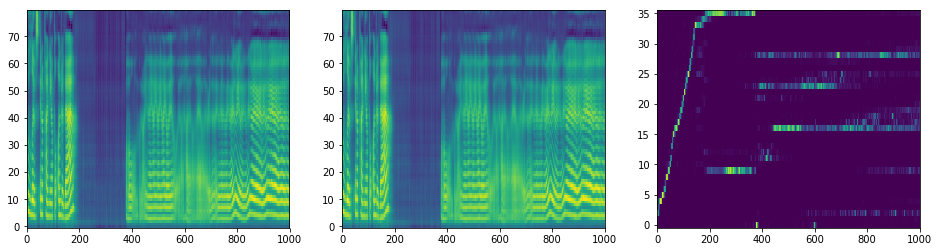

In [48]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

Play it back. The first is the raw audio output, and the second is a denoised version.

In [36]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [37]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

#Some troubleshooting

---

This runs pretty smoothly for me, however I've occasionally had the problem where after installing requirements.txt, I'll be prompted to restart the runtime. This is normal--if it asks you to do so, just re-cd into whatever folder you were in before you restarted it and continue as normal. However, sometimes when restarting the runtime the session will fail to reconnect, and will make you start over. If this happens, check to see what your GPU is. On anything other than P100 and V100, the card may be running out of memory and you will be unable to reconnect. Because of the way Colab works, if you've been training a lot recently it may downgrade you temporarily, and you'll have to wait some time before it upgrades you again. There's no documentation on how this works, so you'll just have to wait and see. If you're really eager, you can subscribe to Colab Pro and it'll give you priority access to better GPUs, but it's still no garauntee that you won't be downgraded from time to time.

__During training__

Problem: Runtime Error: shape '[1, 1, 1234]' is invalid for input size of [12345]

Fix: Make sure your WAV files are mono, and not stereo.

Thanks to Sticky and Rutherfox from the discord for helping debug. Thanks to CamJ for fixes to several filepaths and making it generally more user-friendly. Thanks to Samurzl for the IPA preprocessing integration and the code used for processing the synthesized text.

MISC

On training smaller datasets: https://github.com/NVIDIA/tacotron2/issues/344

!!SCRIPP'S TESTING ZONE DON'T RUN ME!!

In [ ]:
pwd

In [ ]:
 cd "/content/drive/My Drive/ML/tacotron2"

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import epitran
import eng_to_ipa as ipa
import re
import os

from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import english_cleaners
from utils import make_arpabet
from hparams import create_hparams
from scipy.io.wavfile import write

In [ ]:
text_file = "sample_texts/alice-in-wonderland.txt"
genlist = []
with open(text_file) as file:
  for line in file:
    genlist.append(line.strip())

print(genlist)

In [ ]:
# Vars to pass: TT2 path, waveglow path, text (.txt file with newlines, or an array), save location, toggle one/multi-file

import argparse
import os
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import epitran
import eng_to_ipa as ipa
import re

from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import english_cleaners
from utils import make_arpabet
from hparams import create_hparams
from scipy.io.wavfile import write

text = ["That quick beige fox jumped in the air over each thin dog, look out, I shout, for he's foiled you again, creating chaos.",
"Are those shy Eurasian footwear, cowboy chaps, or jolly earthmoving headgear.",]

checkpoint_path = "outdir/checkpoint_10000"
waveglow_path = 'waveglow/checkpoints/waveglow_50000'

def synth_multi(checkpoint_path, waveglow_path, text, savedir):

  if not os.path.exists(savedir):
    os.makedirs(savedir)
    print("Creating directory " + savedir + "...")

  hparams = create_hparams()
  hparams.sampling_rate = 22050

  checkpoint_path = "outdir/checkpoint_8000"
  model = load_model(hparams)
  model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
  _ = model.cuda().eval().half()

  waveglow_path = 'waveglow/checkpoints/waveglow_50000'
  waveglow = torch.load(waveglow_path)['model']
  waveglow.cuda().eval().half()
  for k in waveglow.convinv:
      k.float()
  denoiser = Denoiser(waveglow)

  for entry in text:
    wav_name = "_".join(entry.split(" ")[:4]).lower() + ".wav"

    epi = epitran.Epitran('eng-Latn', ligatures = True)
    if hparams.preprocessing == "ipa":
      entry = ipa.convert(english_cleaners(entry))
      foreign_words = re.findall(r"[^ ]{0,}\*", entry)
      for word in foreign_words:
        entry = entry.replace(word, epi.transliterate(word[0:len(word)-1]))
    if hparams.preprocessing == "arpabet":
      entry = make_arpabet(entry)

    # Text sequencer
    if hparams.preprocessing is not None:
      sequence = np.array(text_to_sequence(entry, None))[None, :]
    else:
      sequence = np.array(text_to_sequence(entry, ['english_cleaners']))[None, :]
    sequence = torch.autograd.Variable(
      torch.from_numpy(sequence)).cuda().long()

    # Synthesis
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
    with torch.no_grad():
      audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    audio_denoised = denoiser(audio, strength=0.01)[:, 0]

    # Save audio
    print ("Saving " + wav_name)
    write(os.path.join(savedir, wav_name), hparams.sampling_rate, audio_denoised[0].data.cpu().numpy())
    

if __name__ == '__main__':

  parser = argparse.ArgumentParser()

  parser.add_argument('-t', '--tt2_checkpoint_path', type=str, default="tacotron2_statedict.pt",
                        required=False, help='Tacotron2 checkpoint to load')
  parser.add_argument('-w', '--waveglow_checkpoint_path', type=str, default="waveglow/waveglow_256channels_universal_v5.pt",
                        required=False, help='waveglow checkpoint to load')
  parser.add_argument('-f', '--text_file', type=str, 
                        help='Text file or list to generate audio from.')
  parser.add_argument('-o', '--output_directory', type=str, default="savedir",
                        required=False, help='Output directory to save to. Defaults to savedir.')
  
  args = parser.parse_args()

  synth_multi(args.tt2_checkpoint_path, args.waveglow_checkpoint_path, args.text_file, args.output_directory)

In [ ]:
 cd "/content/drive/My Drive/ML/tacotron2"

In [ ]:
!python generate_from_file.py -t "outdir/checkpoint_20000" -w "waveglow/checkpoints/waveglow_130000" -f "sample_texts/all-phonemes.txt"

In [ ]:
import IPython.display as ipd
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import epitran
import eng_to_ipa as ipa
import re

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from text.cleaners import english_cleaners



text = "Alice opened the door and found that it led into a small passage, not much larger than a rat-hole. "
text_debug = text

#epitran preprocessing loop
hparams = create_hparams()
epi = epitran.Epitran('eng-Latn')
if hparams.ipa_preprocessing:
  text = ipa.convert(english_cleaners(text))
  foreign_words = re.findall(r"[^ ]{0,}\*", text)
  for word in foreign_words:
    debug_text = text.replace(word, epi.transliterate(word[0:len(word)-1]))

def ord_debug_simple(entry):
  chars = []
  wordlist = []
  list = entry.split()
  for word in list:
    chars = []
    chars += word
    chars = [ord(char) for char in chars]
    wordlist.append(chars)
      
  return str(wordlist)

print("english_cleaners: \t" + english_cleaners(text_debug))
print("eng_to_ipa: \t\t" + ipa.convert(english_cleaners(text_debug)))
print("epitran: \t\t" + epi.transliterate(english_cleaners(text_debug)))
print("\n")
print("hybrid_mix: \t\t" + debug_text)
print("hybrid_mix_cleaned: \t" + english_cleaners(debug_text))
print("\n")
print("english_cleaners_ORD: \t" + ord_debug_simple(text_debug))
print("hybrid_mix_ORD: \t" + ord_debug_simple(debug_text))
print("hybrid_cleanded_ORD: \t" + ord_debug_simple(english_cleaners(debug_text)))
print("\n")
print("eng_to_ipa_ORD: \t" + ord_debug_simple(ipa.convert(english_cleaners(text_debug))))
print("epitran_ORD: \t\t" + ord_debug_simple(epi.transliterate(english_cleaners(text_debug))))

#text sequencer
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

In [ ]:
#Tester

from hparams import create_hparams
import random
import numpy as np
import torch
import torch.utils.data
import re
from text import cleaners
from text.symbols import symbols

import layers
from utils import load_wav_to_torch, load_filepaths_and_text, convert_to_ipa, convert_to_arpa
from text import text_to_sequence
from text import cleaners

apath = '../dataset/train.txt'
hparams = create_hparams()

class TextMelLoader(torch.utils.data.Dataset):
    """
        1) loads audio,text pairs
        2) normalizes text and converts them to sequences of one-hot vectors
        3) computes mel-spectrograms from audio files.
    """
    def __init__(self, audiopaths_and_text, hparams):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)[:5]
        self.text_cleaners = hparams.text_cleaners
        print(self.audiopaths_and_text)
        if hparams.preprocessing is not None:
            if hparams.preprocessing == 'ipa':
                convert_to_ipa(self.audiopaths_and_text)
            if hparams.preprocessing == 'arpabet':
                convert_to_arpa(self.audiopaths_and_text)
            self.text_cleaners = None
        print(self.audiopaths_and_text)
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.load_mel_from_disk = hparams.load_mel_from_disk
        self.stft = layers.TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)
        random.seed(hparams.seed)
        random.shuffle(self.audiopaths_and_text)

    def get_mel_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
        text = self.get_text(text)
        mel = self.get_mel(audiopath)
        return (text, mel)

    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != self.stft.sampling_rate:
                raise ValueError("{} {} SR doesn't match target {} SR".format(
                    sampling_rate, self.stft.sampling_rate))
            audio_norm = audio / self.max_wav_value
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = self.stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels))

        return melspec

    def get_text(self, text):
        text_norm = torch.IntTensor(text_to_sequence(text, self.text_cleaners))
        return text_norm

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)


def text_to_sequence(text, cleaner_names):
  '''Converts a string of text to a sequence of IDs corresponding to the symbols in the text.

    The text can optionally have ARPAbet sequences enclosed in curly braces embedded
    in it. For example, "Turn left on {HH AW1 S S T AH0 N} Street."

    Args:
      text: string to convert to a sequence
      cleaner_names: names of the cleaner functions to run the text through

    Returns:
      List of integers corresponding to the symbols in the text
  '''
  sequence = []

  # Check for curly braces and treat their contents as ARPAbet:
  while len(text):
    m = _curly_re.match(text)
    print(m)
    if not m:
      sequence += _symbols_to_sequence(_clean_text(text, cleaner_names))
      break
    sequence += _symbols_to_sequence(_clean_text(m.group(1), cleaner_names))
    sequence += _arpabet_to_sequence(m.group(2))
    text = m.group(3)

  return sequence

def sequence_to_text(sequence):
  '''Converts a sequence of IDs back to a string'''
  result = ''
  for symbol_id in sequence:
    if symbol_id in _id_to_symbol:
      s = _id_to_symbol[symbol_id]
      # Enclose ARPAbet back in curly braces:
      if len(s) > 1 and s[0] == '@':
        s = '{%s}' % s[1:]
      result += s
  return result.replace('}{', ' ')


def _clean_text(text, cleaner_names):
  if cleaner_names is None:
    return text
  else:
    for name in cleaner_names:
      cleaner = getattr(cleaners, name)
      if not cleaner:
        raise Exception('Unknown cleaner: %s' % name)
      text = cleaner(text)
  return text


def _symbols_to_sequence(symbols):
  return [_symbol_to_id[s] for s in symbols if _should_keep_symbol(s)]


def _arpabet_to_sequence(text):
  return _symbols_to_sequence(['@' + s for s in text.split()])


def _should_keep_symbol(s):
  return s in _symbol_to_id and s is not '_' and s is not '~'


text = "{DH AH0} {B EY1 ZH} {HH Y UW1} {AA1 N} {DH AH0} {W AO1 T ER0 Z} {AH1 V} {DH AH0} {L AA1 K} {IH0 M P R EH1 S T} {AO1 L}, {IH0 N K L UW1 D IH0 NG} {DH AH0} {F R EH1 N CH} {K W IY1 N}, {B IH0 F AO1 R} {SH IY1} {HH ER1 D} {DH AE1 T} {S IH1 M F AH0 N IY0} {AH0 G EH1 N} {JH AH1 S T} {AE1 Z} {Y AH1 NG} {AA1 R TH ER0} {W AA1 N T AH0 D}."
# Mappings from symbol to numeric ID and vice versa:
_symbol_to_id = {s: i for i, s in enumerate(symbols)}
_id_to_symbol = {i: s for i, s in enumerate(symbols)}

# Regular expression matching text enclosed in curly braces:
_curly_re = re.compile(r'(.*?)\{(.+?)\}(.*)')

seq = text_to_sequence(text, None)
print(seq)